In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


### We group the dataset by well name to add variables well by well

In [2]:
grouped = training_data.groupby(['Well Name'])

###  We create a new variable representing the absolute distance of a deposit to an upper marine context (younger)

In [3]:
new_var = pd.DataFrame()

for key in grouped.groups.keys():
    
    NM_M = grouped.get_group(key)['NM_M'].values
    
    #We create a temporary dataframe that we reset for every well
    temp_df = pd.DataFrame()
    temp_df['Depth'] = grouped.get_group(key)['Depth']
    temp_df['Well Name'] = [key for _ in range(len(NM_M))]
    
    #We initialize a new variable
    dist_mar_up = np.zeros(len(NM_M))

    # A variable counting the interval from the ipper marine deposit
    # We initialize it to -99999 since we do not know what's abpve the first log
    count = -99999
    
    for i in range(len(NM_M)):
               
        if ((NM_M[i] == 1) & (count>-99999)):
            
            count+=0.5
            dist_mar_up[i] += count
            
        elif NM_M[i] == 2:
            
            count=0
        
        else:
            dist_mar_up[i] = count

    temp_df['dist_mar_up'] = dist_mar_up
    
    # We append each well variable to a larger dataframe
    # We use a dataframe to preserve the index
    new_var = new_var.append(temp_df)

### We concatenate our new variable with the training_data Dataframe

In [4]:
#We don't use merge as it creates duplicates for curious reasons that we later have to drop
new_var = new_var.sort_index()
new_var = new_var.drop(['Well Name','Depth'],axis=1)
training_data =  pd.concat([training_data,new_var],axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,-99999.0
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,-99999.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,-99999.0
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,-99999.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,-99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,0.0
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,0.0
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,0.0
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,0.0


### We create a second variable that gives the absolute distance of non-marine sediments to an older (deeper) marine episode

In [5]:
new_var = pd.DataFrame()

for key in grouped.groups.keys():
    
    NM_M = grouped.get_group(key)['NM_M'].values
    
    temp_df = pd.DataFrame()
    temp_df['Depth'] = grouped.get_group(key)['Depth']
    temp_df['Well Name'] = [key for _ in range(len(NM_M))]
        
    dist_mar_down = np.zeros(len(NM_M))
    count = -99999
    
    # same process with a reverse loop
    for i in range(len(NM_M)-1,-1,-1):
               
        if ((NM_M[i] == 1) & (count>-99999)):
            
            count+=0.5
            dist_mar_down[i] += count
            
        elif NM_M[i] == 2:            
            count=0
            
        else:
            dist_mar_down[i] = count
            
    temp_df['dist_mar_down'] = dist_mar_down
        
    new_var = new_var.append(temp_df)

### We again merge this new variable with our Dataframe

In [6]:
new_var = new_var.sort_index()
new_var =new_var.drop(['Well Name','Depth'],axis=1)
training_data =  pd.concat([training_data,new_var],axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up,dist_mar_down
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,-99999.0,21.5
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,-99999.0,21.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,-99999.0,20.5
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,-99999.0,20.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,-99999.0,19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,0.0,0.0
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,0.0,0.0
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,0.0,0.0
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,0.0,0.0


### Assign category integer to Formation variable

In [7]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
training_data['Formation_category'] = LE.fit_transform(training_data.Formation)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up,dist_mar_down,Formation_category
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000,4149.000000,4149.00000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,-9781.547481,5.09677,6.434322
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644,29716.387851,7.75078,4.722771
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-99999.000000,0.00000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000,0.000000,0.00000,2.000000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000,0.000000,0.00000,7.000000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000,5.500000,8.50000,12.000000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,46.000000,46.00000,13.000000


### We import the ensemble module from sklearn and the metrics module

In [8]:
from sklearn import metrics
from sklearn import ensemble

### Let's see how well NM_M variable discriminates facies

In [9]:
id_NM = training_data.NM_M == 1
id_M = training_data.NM_M == 2

#we count with th GR variable since there is no missing value
NM_count = training_data[id_NM].groupby(['Facies'])['GR'].count()
M_count = training_data[id_M].groupby(['Facies'])['GR'].count()

In [10]:
pos_NM = list(np.arange(0.1,8.1,1))
pos_M = list(np.arange(1.5,9.5,1)) 
pos_M

[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]

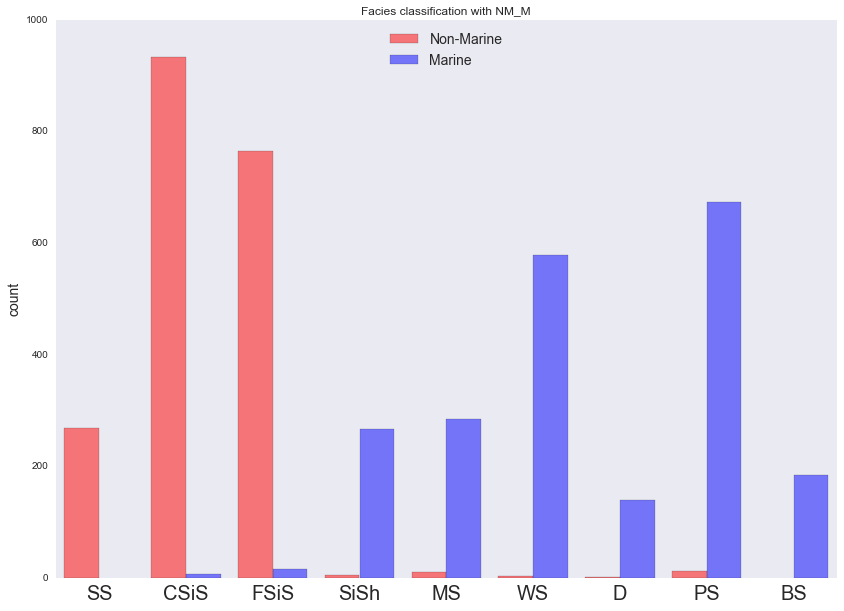

In [11]:
import seaborn as sns
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
fig, ax = plt.subplots(figsize=(14,10))

plt.bar(pos_NM, NM_count.values, 0.4,
                 alpha=0.5,
                 color='r',
                 label='Non-Marine')

plt.bar(pos_M, M_count.values, 0.4,
                 alpha=0.5,
                 color='b',
                 label='Marine')

# Setting axis labels and ticks
ax.set_ylabel('count',fontsize=14)
ax.set_title('Facies classification with NM_M')
ax.set_xticks(np.arange(0.5,10))
ax.set_xticklabels(facies_labels, fontsize=20)
ax.set_xlim([0,9])

# Adding the legend and showing the plot
plt.legend(['Non-Marine','Marine'], loc='upper center', fontsize=14)
plt.grid()
plt.show()

### We can live with a small percentage of misclassification from the NM_M variable. We separate our dataset in marine and non-marine sediments assuming that facies 1-3 are NM and 4-9 are M (NM_M ==2)

In [12]:
NM_training_data = training_data[id_NM]
M_training_data = training_data[id_M]

# The algorithm can't use directly NaN but we don't have to drop the data if we assign an extreme value
NM_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)
M_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)

NM_training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,dist_mar_up,dist_mar_down,Formation_category
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.0,1998.000000,1998.000000,1998.000000,1998.000000
mean,2.314314,2867.824825,74.877176,0.530167,5.373860,16.760651,-18866.134227,1.0,0.511736,-20312.132382,10.583834,6.546046
std,0.854635,133.370818,15.233573,0.160396,6.147445,7.699085,39136.744191,0.0,0.288464,40251.953018,8.165698,4.357650
min,1.000000,2573.500000,26.060000,-0.025949,-19.900000,3.950000,-99999.000000,1.0,0.000000,-99999.000000,0.500000,0.000000
25%,2.000000,2776.625000,64.378000,0.438000,2.700000,11.950000,2.486000,1.0,0.259250,1.000000,4.000000,3.000000
50%,2.000000,2893.750000,73.704000,0.542000,5.800000,14.908750,3.057000,1.0,0.500000,6.000000,9.000000,7.000000
75%,3.000000,2969.000000,83.936000,0.633000,9.300000,19.212750,3.364750,1.0,0.763000,12.000000,15.000000,11.000000
max,8.000000,3111.500000,183.375000,0.966000,19.257000,84.400000,5.100000,1.0,1.000000,46.000000,46.000000,13.000000


### We drop unused variables for marine and non-marine dataset (we prepare the list here)
#### N.B this operation is based on geological knowledge and feature importance from previous tests

In [16]:
nm_drop_list = ['Formation', 'Well Name', 'Depth',
                                     'Facies','DeltaPHI','PE','NM_M','RELPOS']
m_drop_list = ['Formation', 'Well Name', 'Depth',
                                      'Facies','dist_mar_down','dist_mar_up','PE','NM_M','PHIND']

In [17]:
#We prepare our estimator
clf = ensemble.RandomForestClassifier(n_estimators=500,n_jobs=-1)

In [18]:
names = list(np.unique(training_data['Well Name']))

nm_grouped = NM_training_data.groupby(['Well Name'])
m_grouped = M_training_data.groupby(['Well Name'])

new_df = pd.DataFrame()

scores = []

for name in names:

    temp_df = pd.DataFrame()

    # We need to isolate Recruit F9 since it has only marine facies
    if name == 'Recruit F9':

        #Build list of well names and remove blind well (and remove recruit F9 for NM)
        m_train_names = names.copy()
        m_train_names.remove(name)

        # Do it for marine sediments
        m_test = m_grouped.get_group(name)
        m_test_depth = m_test.Depth
        m_X_test = m_test.drop(m_drop_list, axis=1).values
        y_test = m_test['Facies'].values

        m_train = pd.DataFrame()

        for train_name in m_train_names:
            m_train = m_train.append(m_grouped.get_group(train_name))

        id_train_M = m_train.Facies >= 4
        m_train = m_train [id_train_M]
        m_X_train = m_train.drop(m_drop_list, axis=1).values
        m_y_train = m_train['Facies'].values

        #The prediction begins

        #We start with oversampling minority classes
#             m_X_train, m_y_train = smt.fit_sample(m_X_train,m_y_train)

        #Then we do random forest classification
        clf.fit(m_X_train, m_y_train)
        y_pred = clf.predict(m_X_test)

    else:

        #Build list of well names and remove blind well (and remove recruit F9 for NM)
        m_train_names = names.copy()
        m_train_names.remove(name)   

        nm_train_names = m_train_names.copy()
        nm_train_names.remove('Recruit F9')


        # Do it for non-marine sediments
        nm_test = nm_grouped.get_group(name)
        nm_test_depth = nm_test.Depth
        nm_X_test = nm_test.drop(nm_drop_list, axis=1).values
        nm_y_test = nm_test['Facies'].values

        nm_train = pd.DataFrame()

        for train_name in nm_train_names:
            nm_train = nm_train.append(nm_grouped.get_group(train_name))

        id_train_NM = nm_train.Facies <= 3
        nm_train = nm_train [id_train_NM]
        nm_X_train = nm_train.drop(nm_drop_list, axis=1).values
        nm_y_train = nm_train['Facies'].values

        #Then we do random forest classification
        clf.fit(nm_X_train, nm_y_train)
        nm_y_pred = clf.predict(nm_X_test)

        print(clf.feature_importances_)

        #*********************************************************************#

        # Do it for marine sediments
        m_test = m_grouped.get_group(name)
        m_test_depth = m_test.Depth
        m_X_test = m_test.drop(m_drop_list, axis=1).values
        m_y_test = m_test['Facies'].values

        m_train = pd.DataFrame()

        for train_name in m_train_names:
            m_train = m_train.append(m_grouped.get_group(train_name))

        id_train_M = m_train.Facies >= 4
        m_train = m_train [id_train_M]
        m_X_train = m_train.drop(m_drop_list, axis=1).values
        m_y_train = m_train['Facies'].values

        #Then we do random forest classification
        clf.fit(m_X_train, m_y_train)
        m_y_pred = clf.predict(m_X_test)

        print(clf.feature_importances_)

        #================================================================#
        #                         combine results
        #================================================================#

        y_test = np.hstack((nm_y_test,m_y_test))
        y_pred = np.hstack((nm_y_pred,m_y_pred))

    #Scoring
    conf_mat = metrics.confusion_matrix(y_test,y_pred)
    print(conf_mat)
    try:
        score = metrics.f1_score(y_test, y_pred,average='weighted')
    except:
        score = metrics.f1_score(y_test, y_pred)
    scores.append(score)
    print('********')
    print('Blind well is {0}, F1 score : {1:.4%}\n'.format(name,score))

    if name == 'Recruit F9':
        depth = m_test_depth
    else:
        depth = np.hstack((nm_test_depth,m_test_depth))

    idx = np.argsort(depth)
    temp_df['Depth'] = depth[idx]
    temp_df['True Facies'] = y_test[idx]
    temp_df['Predicted Facies'] = y_pred[idx]

    temp_df['Well Name'] = [name for _ in range(len(depth))]
    new_df = new_df.append(temp_df)

print("="*30)
print('*********** RESULT ***********')
print("="*30)
print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

[ 0.14735351  0.19115289  0.18256259  0.17998085  0.18598084  0.11296933]
[ 0.23751715  0.23763981  0.19810924  0.22228992  0.10444389]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0 98 19  0  0  0  0  0  0]
 [ 1 35 55  0  0  0  0  0  0]
 [ 0  0  0 34  0  2  2  6  0]
 [ 0  0  0  4 10  2  1  9  0]
 [ 0  0  0 13 13 11  7 25  0]
 [ 0  0  0  0  4  0 12  0  0]
 [ 0  0  0  5  7 14 19 47  6]
 [ 0  0  0  0  0  0  0  0  5]]
********
Blind well is ALEXANDER D, F1 score : 57.1089%

[ 0.15331822  0.19023387  0.19455472  0.17514413  0.17951619  0.10723288]
[ 0.24577434  0.23217495  0.19829105  0.22658405  0.09717561]
[[ 0  4  4  0  0  0  0  0  0]
 [ 0 34 21  0  0  0  0  1  0]
 [ 0  6 38  0  0  4  0  3  0]
 [ 0  0  0  5  0  7  0  1  0]
 [ 0  0  1  1  7 17  0  4  0]
 [ 0  0  0 10  1 51  0 25  0]
 [ 0  0  1  0  1  0  0 25  7]
 [ 0  1  2  0  2 20  0 49  1]
 [ 0  0  0  0  0  0  0  0 50]]
********
Blind well is CHURCHMAN BIBLE, F1 score : 54.3186%

[ 0.15997554  0.15332642  0.22634911  0.17236571  0.18957337  0.0984

In [70]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [145]:
#Function modified from initial submission by Brendon Hall

def make_facies_pred_plot(df_pred,facies_colors):
#     make sure logs are sorted by depth
    df_pred = df_pred.sort_values(by='Depth')
    
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    import matplotlib.gridspec as gridspec
    

    gs0 = gridspec.GridSpec(3,4)
    
    fig=plt.figure(figsize=(40,20))
    
    for i,name in zip(range(10),np.unique(df_pred['Well Name'])):
               
        idx = (df_pred['Well Name'] == name)
        cluster_test=np.repeat(np.expand_dims(df_pred[idx]['True Facies'].values,1), 100, 1)
        cluster_pred=np.repeat(np.expand_dims(df_pred[idx]['Predicted Facies'].values,1), 100, 1)
        
        ztop=df_pred[idx].Depth.min(); zbot=df_pred[idx].Depth.max()
        
        gs00 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[i])
       
        ax=[]
        ax.append(plt.subplot(gs00[0]))
        ax.append(plt.subplot(gs00[1]))
        
        im_test=ax[0].imshow(cluster_test, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin=1,vmax=9,extent=[0,100,zbot,ztop])

        im_pred=ax[1].imshow(cluster_pred, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin=1,vmax=9,extent=[0,100,zbot,ztop])

        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im_pred, cax=cax)
        cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                    'SiSh', ' MS ', ' WS ', ' D  ', 
                                    ' PS ', ' BS ']))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

        for i in range(len(ax)):
            ax[i].set_ylim(ztop,zbot)
            ax[i].invert_yaxis()
            ax[i].grid()
            ax[i].locator_params(axis='x', nbins=3)

        ax[0].set_xlabel('Intepreted Facies')
        ax[1].set_xlabel('Predicted Facies')

        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[0].set_xticklabels([])

        fig.suptitle('Well: %s' % name, fontsize=14)

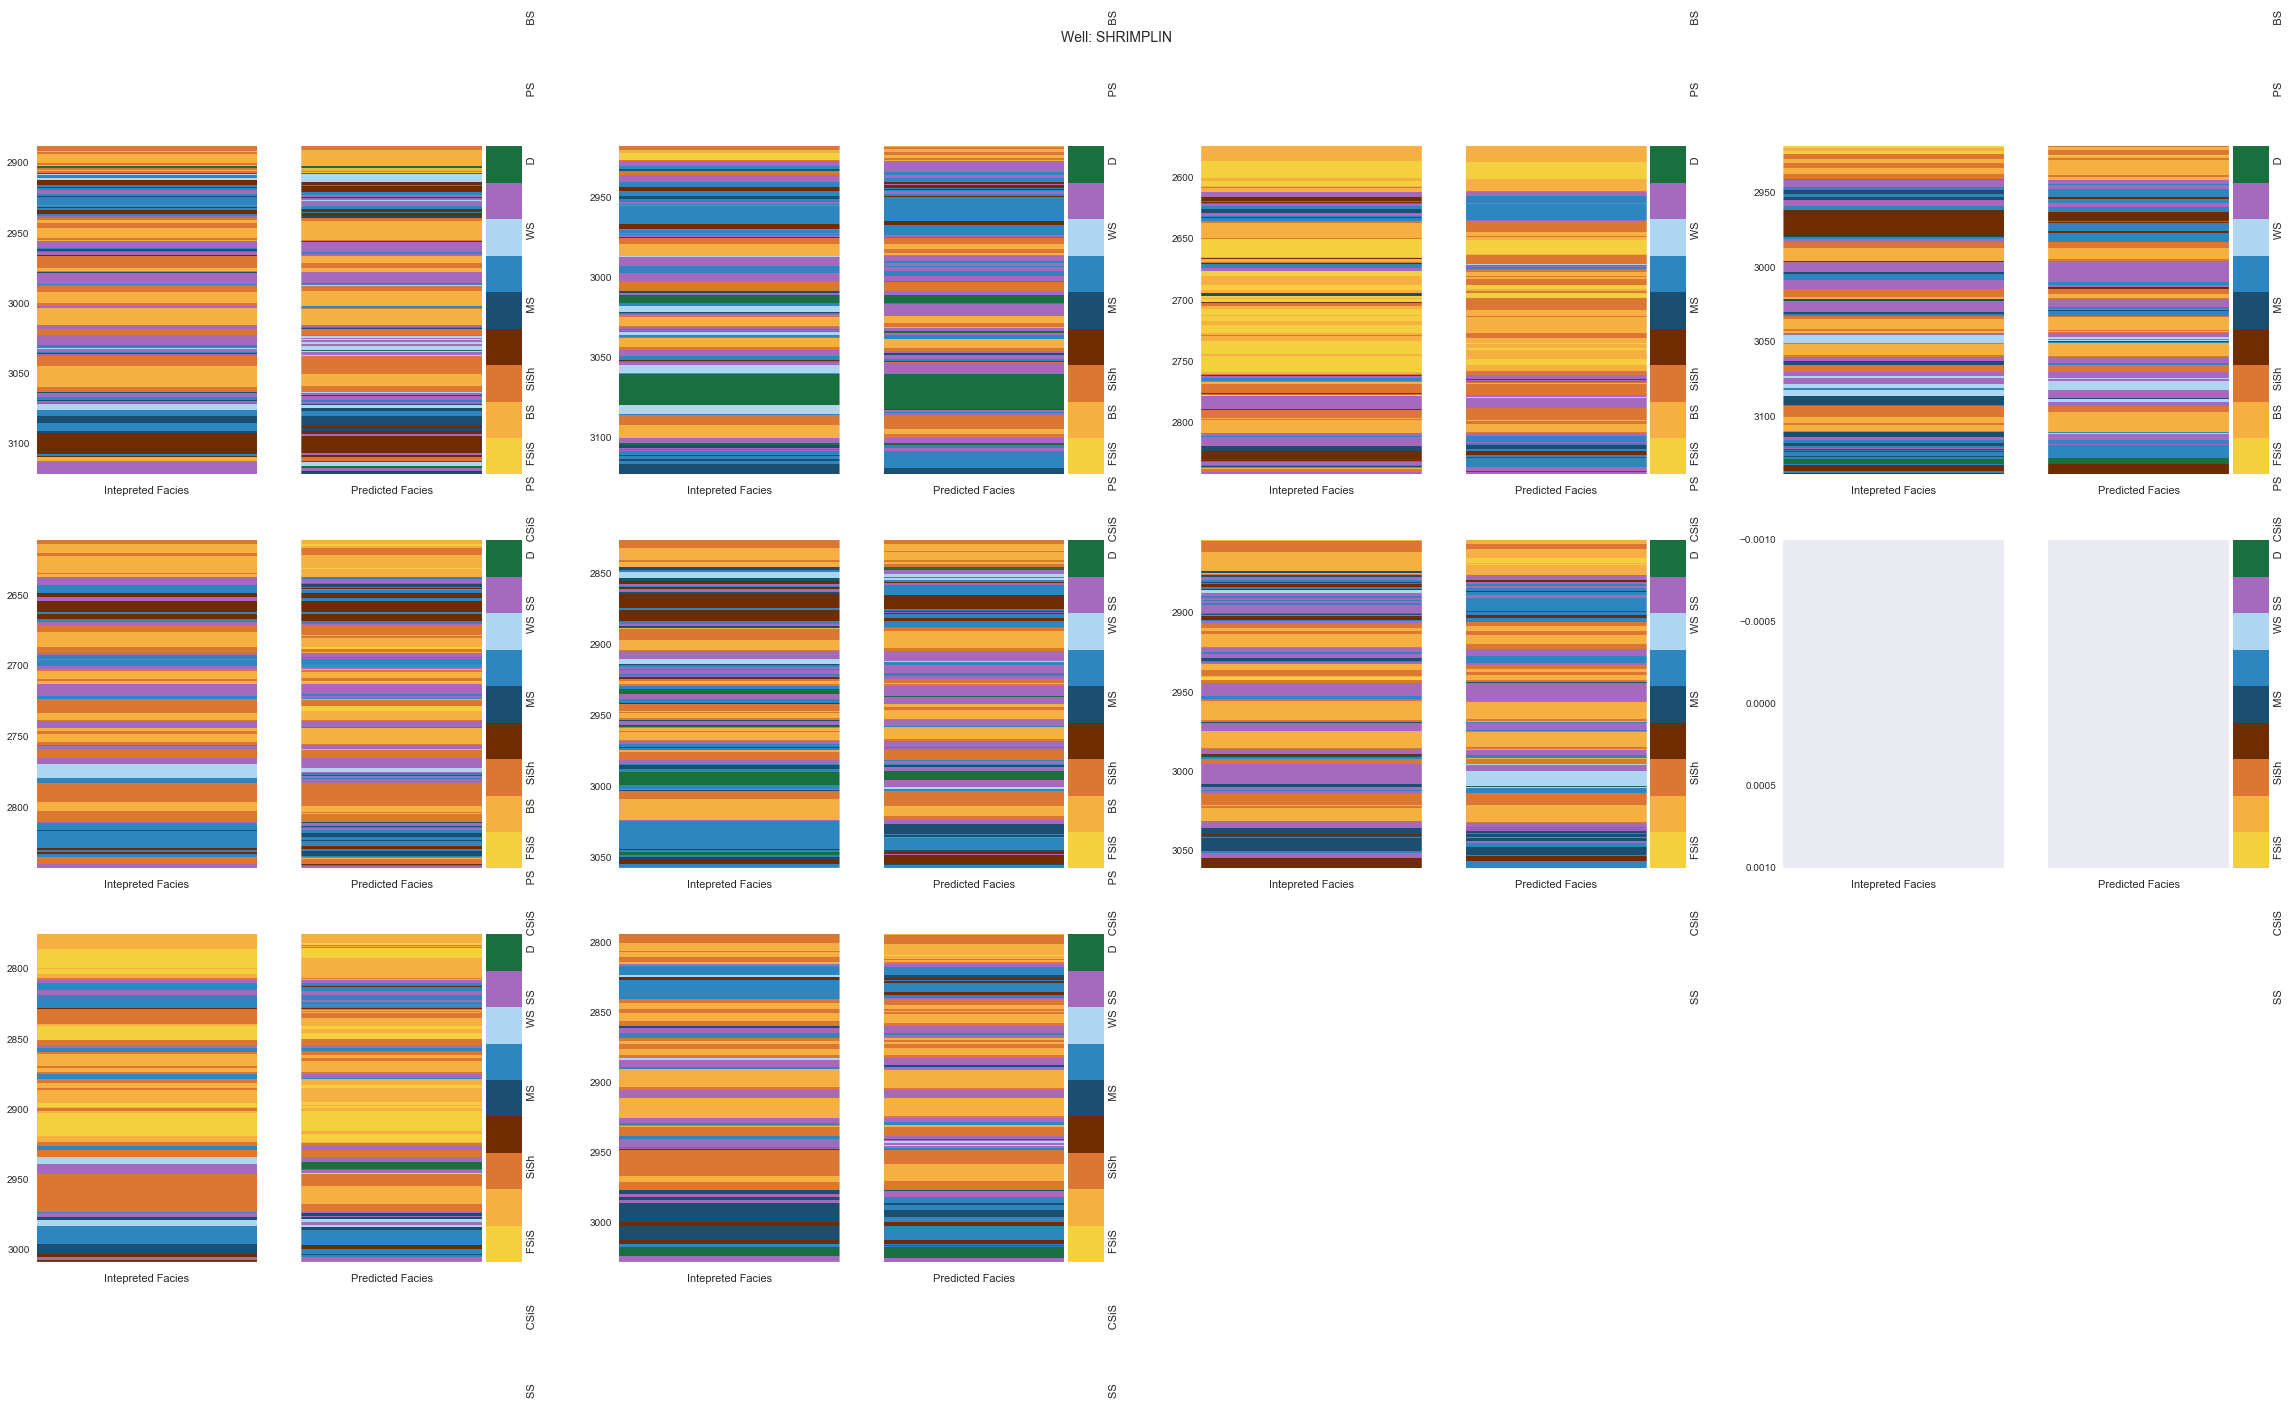

In [146]:
make_facies_pred_plot(new_df,facies_colors)

In [19]:
new_df.to_pickle('Facies_prediction_ml_contest.pkl')

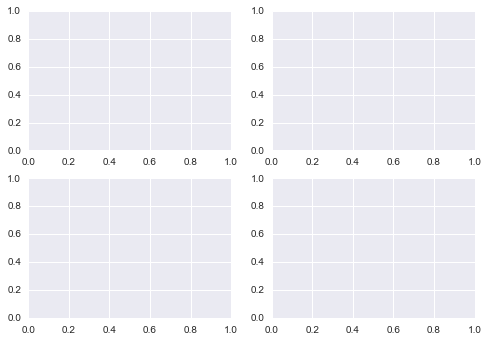

In [95]:
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])